In [241]:
#!pip install statsmodels

In [242]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

In [243]:
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from pandas.tseries.offsets import DateOffset

In [244]:
df = pd.read_csv("/data/BreadBasket_DMS.csv")
df.head()

,Date,Time,Transaction,Item
0,2016-10-30,09:58:11,1,Bread
1,2016-10-30,10:05:34,2,Scandinavian
2,2016-10-30,10:05:34,2,Scandinavian
3,2016-10-30,10:07:57,3,Hot chocolate
4,2016-10-30,10:07:57,3,Jam


In [245]:
df = df.query("Item!='NONE'")

In [246]:
df.info()
df["Qty"]=1

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20507 entries, 0 to 21292
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         20507 non-null  object
 1   Time         20507 non-null  object
 2   Transaction  20507 non-null  int64 
 3   Item         20507 non-null  object
dtypes: int64(1), object(3)
memory usage: 801.1+ KB


In [247]:
daily_items = df.groupby(["Date","Item"])["Qty"].sum().reset_index()

In [248]:
#Filtering Top 3 product
top_items = daily_items.groupby("Item")["Qty"].sum().sort_values(ascending=False)[0:3].index
top_items

Index(['Coffee', 'Bread', 'Tea'], dtype='object', name='Item')

In [249]:
top_daily_items = daily_items[daily_items["Item"].isin(top_items)]
top_daily_items

,Date,Item,Qty
1,2016-10-30,Bread,29
4,2016-10-30,Coffee,33
24,2016-10-30,Tea,12
26,2016-10-31,Bread,24
28,2016-10-31,Coffee,60
...,...,...,...
3612,2017-04-08,Coffee,41
3633,2017-04-08,Tea,9
3639,2017-04-09,Bread,9
3642,2017-04-09,Coffee,17


In [250]:
top_daily_items = top_daily_items.sort_values(by=["Item","Date"])
top_daily_items

,Date,Item,Qty
1,2016-10-30,Bread,29
26,2016-10-31,Bread,24
50,2016-11-01,Bread,21
73,2016-11-02,Bread,17
95,2016-11-03,Bread,26
...,...,...,...
3554,2017-04-05,Tea,14
3578,2017-04-06,Tea,11
3599,2017-04-07,Tea,6
3633,2017-04-08,Tea,9


In [251]:
top_daily_items["Date"] = pd.to_datetime(top_daily_items["Date"])
top_daily_items.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 475 entries, 1 to 3658
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    475 non-null    datetime64[ns]
 1   Item    475 non-null    object        
 2   Qty     475 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 14.8+ KB


In [252]:
df_coffee = top_daily_items[top_daily_items['Item'] == "Coffee"]
df_tea = top_daily_items[top_daily_items['Item'] == "Tea"]
df_bread = top_daily_items[top_daily_items['Item'] == "Bread"]

In [253]:
df_coffee.shape, df_tea.shape, df_bread.shape

((158, 3), (158, 3), (159, 3))

In [254]:
df_coffee = df_coffee[['Date','Qty']]
df_tea = df_tea[['Date','Qty']]
df_bread = df_bread[['Date','Qty']]

In [255]:
df_coffee.set_index('Date', inplace=True)
df_tea.set_index('Date', inplace=True)
df_bread.set_index('Date', inplace=True)

<AxesSubplot:xlabel='Date'>

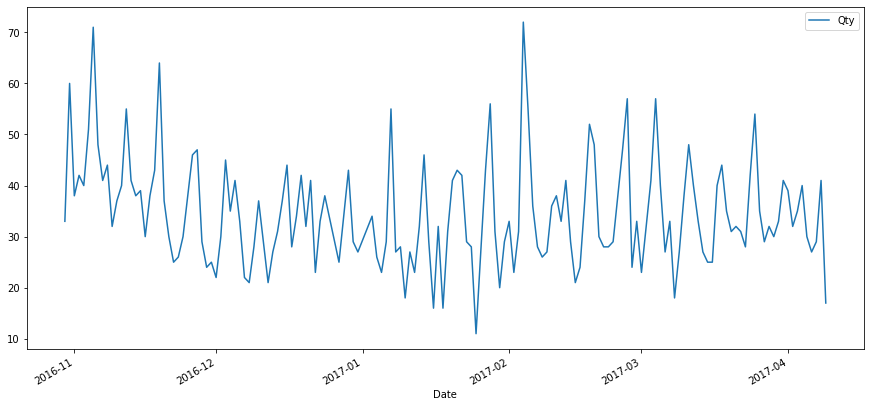

In [256]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 7
df_coffee.plot()

In [257]:
Qty_result=adfuller(df_coffee['Qty'])

In [258]:
Qty_result

(-3.231959639429196,
 0.018207677607260886,
 13,
 144,
 {'1%': -3.476597917537401,
  '5%': -2.8818291230495543,
  '10%': -2.5775887982253085},
 997.5022046747692)

In [259]:
def adfuller_test(Qty, item):
    result=adfuller(Qty)
    print ("Item: ", item)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")

In [260]:
adfuller_test(df_coffee['Qty'], "Coffee")

Item:  Coffee
ADF Test Statistic : -3.231959639429196
p-value : 0.018207677607260886
#Lags Used : 13
Number of Observations : 144
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [261]:
adfuller_test(df_tea['Qty'], "Tea")

Item:  Tea
ADF Test Statistic : -3.900603409702
p-value : 0.002030410828295478
#Lags Used : 6
Number of Observations : 151
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [262]:
adfuller_test(df_bread['Qty'], "Bread")

Item:  Bread
ADF Test Statistic : -3.1713572839272346
p-value : 0.02170365726149992
#Lags Used : 6
Number of Observations : 152
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [263]:
df_coffee['First_Difference'] = df_coffee['Qty'] - df_coffee['Qty'].shift(1)
df_tea['First_Difference'] = df_tea['Qty'] - df_tea['Qty'].shift(1)
df_bread['First_Difference'] = df_bread['Qty'] - df_bread['Qty'].shift(1)

In [264]:
adfuller_test(df_coffee['First_Difference'].dropna(), "Coffee")

Item:  Coffee
ADF Test Statistic : -5.909174996431334
p-value : 2.6639376308000976e-07
#Lags Used : 12
Number of Observations : 144
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [265]:
adfuller_test(df_tea['First_Difference'].dropna(), "Tea")

Item:  Tea
ADF Test Statistic : -11.434830085861137
p-value : 6.385539541160188e-21
#Lags Used : 5
Number of Observations : 151
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [266]:
adfuller_test(df_bread['First_Difference'].dropna(), "Bread")

Item:  Bread
ADF Test Statistic : -14.503697927308039
p-value : 5.8758825347541035e-27
#Lags Used : 5
Number of Observations : 152
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


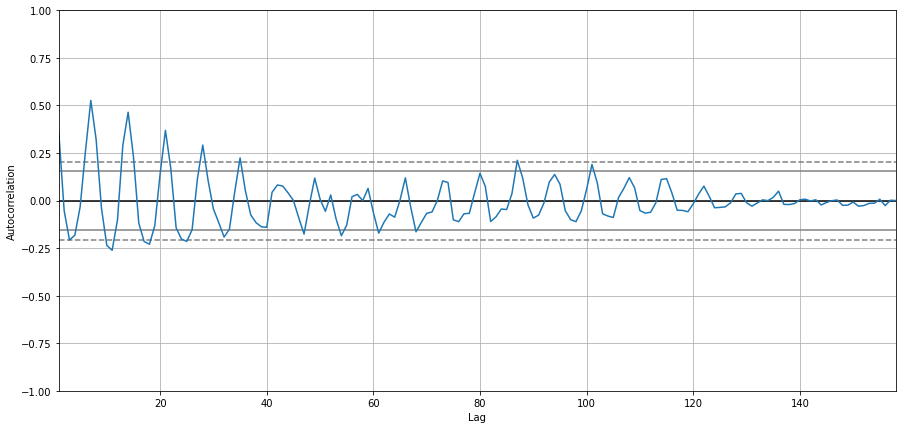

In [267]:
autocorrelation_plot(df_coffee['Qty'])
plt.show()

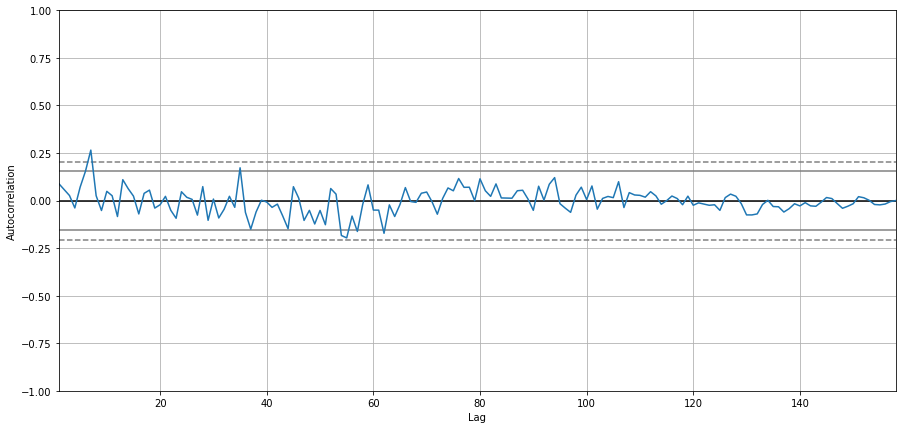

In [268]:
autocorrelation_plot(df_tea['Qty'])
plt.show()

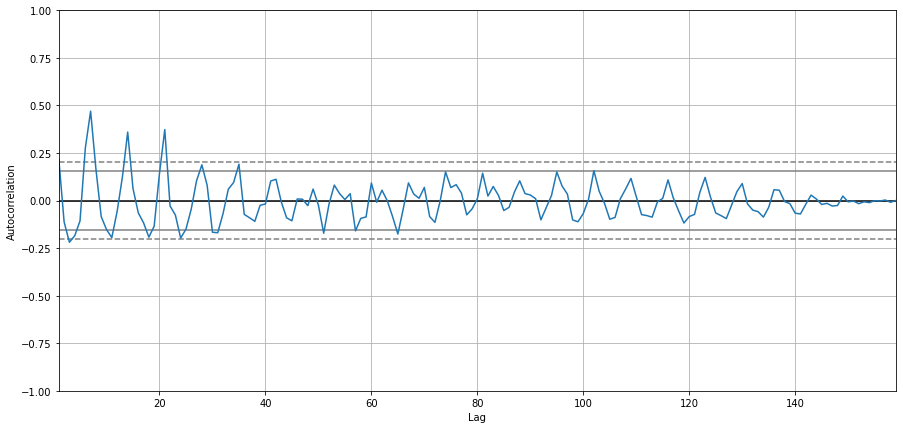

In [269]:
autocorrelation_plot(df_bread['Qty'])
plt.show()

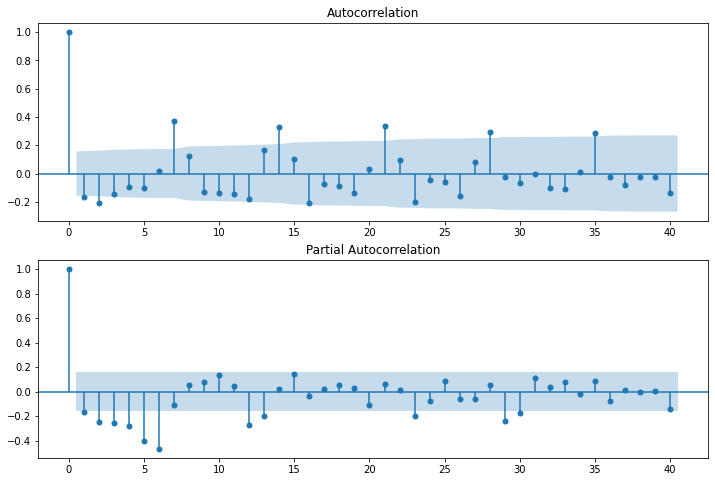

In [270]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_coffee['First_Difference'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_coffee['First_Difference'].dropna(),lags=40,ax=ax2)

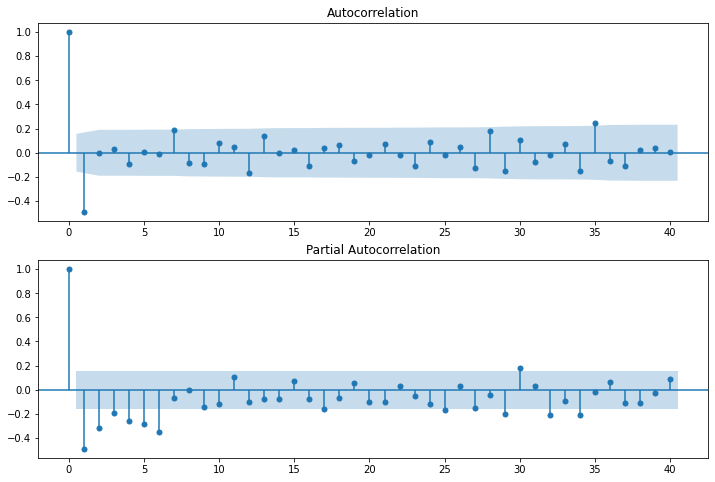

In [271]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_tea['First_Difference'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_tea['First_Difference'].dropna(),lags=40,ax=ax2)

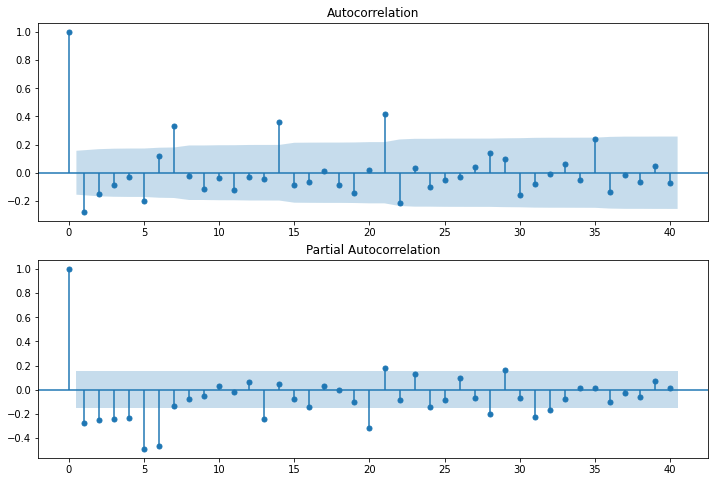

In [272]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_bread['First_Difference'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_bread['First_Difference'].dropna(),lags=40,ax=ax2)

In [273]:
model=ARIMA(df_coffee['Qty'],order=(1,1,0))
model_fit=model.fit()
model_fit.summary()

/tmp/pip_packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/tmp/pip_packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. fore

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D.Qty   No. Observations:                  157
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -607.299
Method:                       css-mle   S.D. of innovations             11.578
Date:                Wed, 18 Jan 2023   AIC                           1220.597
Time:                        15:00:04   BIC                           1229.766
Sample:                             1   HQIC                          1224.321
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.1050      0.787     -0.133      0.894      -1.648       1.438
ar.L1.D.Qty    -0.1748      0.081     -2.162      0.031      -0.333      -0.016
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -5.7224           +0.0000j            5.7224            0.5000
-----------------------------------------------------------------------------
"""

<AxesSubplot:xlabel='Date'>

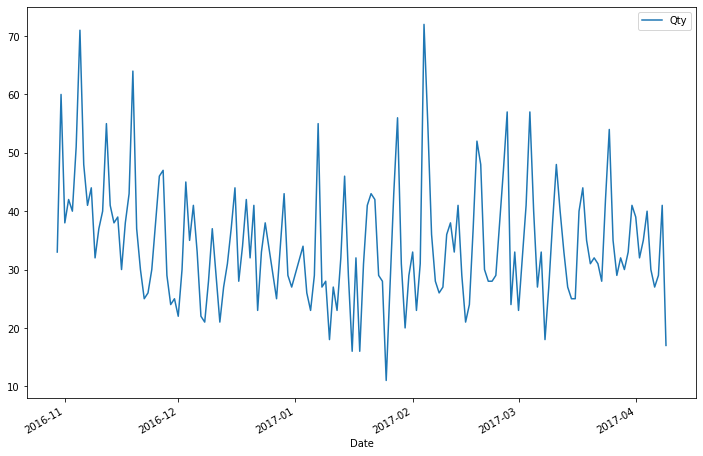

In [286]:
df_coffee['forecast'] = "NaN"
df_coffee.iloc[151:,2]=model_fit.predict(start=151,end=157,dynamic=True)
df_coffee[['Qty','forecast']].plot(figsize=(12,8))

In [289]:
df_coffee.tail(14)

,Qty,First_Difference,forecast
Date,,,
2017-03-27,29,-6.0,NaN
2017-03-28,32,3.0,NaN
2017-03-29,30,-2.0,NaN
2017-03-30,33,3.0,NaN
2017-03-31,41,8.0,NaN
2017-04-01,39,-2.0,NaN
2017-04-02,32,-7.0,NaN
2017-04-03,35,3.0,22.4965
2017-04-04,40,5.0,24.4074


/tmp/pip_packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/tmp/pip_packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<AxesSubplot:xlabel='Date'>

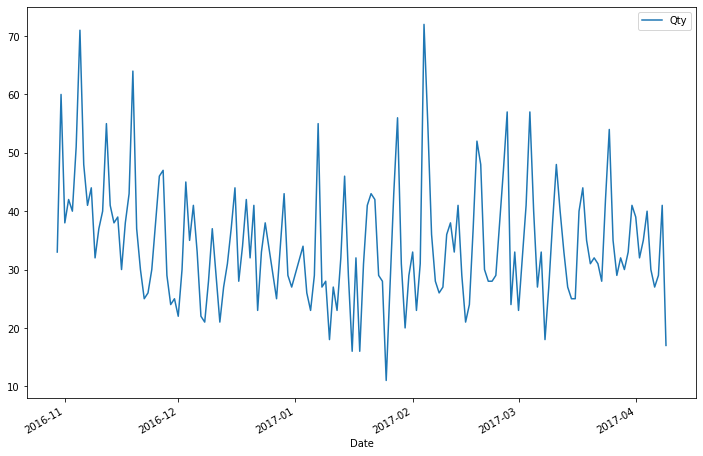

In [290]:
model=sm.tsa.statespace.SARIMAX(df_coffee['Qty'],order=(1, 1, 0),seasonal_order=(1,1,1,7))
results=model.fit()
df_coffee.iloc[151:, 2]=results.predict(start=151,end=157,dynamic=True)
df_coffee[['Qty','forecast']].plot(figsize=(12,8))

In [ ]:
df_coffee.index

In [ ]:
future_df.iloc[158:,2]

In [240]:
future_dates=[df_coffee.index[-1]+ DateOffset(days=x)for x in range(0,7)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df_coffee.columns)
future_df=pd.concat([df_coffee,future_datest_df])
future_df.index.name = 'Date'
#print(future_df.tail(14))
future_df.iloc[158:,2] = results.predict(start = 158, end = 164, dynamic= True)
print(future_df.tail(14))
future_df[['Qty', 'forecast']].plot(figsize=(12, 6))

/tmp/pip_packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


,Qty,First_Difference,forecast
Date,,,
2017-04-02,32,-7.0,NaN
2017-04-03,35,3.0,22.496470
2017-04-04,40,5.0,24.407403
2017-04-05,30,-10.0,20.884598
2017-04-06,27,-3.0,22.165862
2017-04-07,29,2.0,33.742098
2017-04-08,41,12.0,39.967280
2017-04-09,17,-24.0,28.293635
2017-04-10,NaN,NaN,NaN


In [239]:
results.predict(start = 158, end = 164, dynamic= True)

/tmp/pip_packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


158    18.599737
159    18.839309
160    14.815951
161    14.516411
162    22.627706
163    29.005895
164    14.371266
Name: predicted_mean, dtype: float64